<a href="https://colab.research.google.com/github/Mountain-C/Class-Projects/blob/master/Class-Projects/Codes/Numerical_Analysis/Final_Poisson_Dirichlet_Simple_Version_Alternate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[[ 0.          0.512       4.096      13.824      32.768      64.        ]
 [ 0.64        2.98180848  7.10101411 14.7361888  22.10738521  1.        ]
 [ 2.56        3.67421983  6.06577115  9.62089988 11.61380005  1.        ]
 [ 5.76        3.35144368  3.86695079  5.28140752         nan         nan]
 [10.24        2.20175612  1.2934688          nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan]]


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


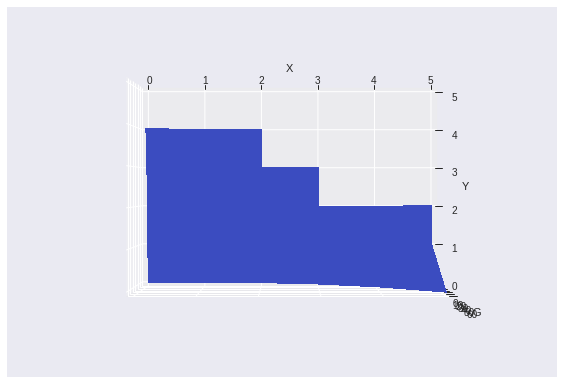

In [ ]:

from scipy import sparse
from scipy.sparse.linalg import spsolve
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

def rhs(x, y):
    # Element-wise multiplication
    return np.multiply(x, (x-y)**3)


def bc_dirichlet(x, y, m):

    bc = np.zeros((m + 1, m + 1))
    bc[:, 0] = y[:, 0]**2
    bc[:, m] = np.ones((m + 1, 1)).ravel()
    bc[0, :] = x[0, :]**3
    bc[m, :] = np.ones((1, m+1)).ravel()
    return bc

def generate_A(k):
    """Create the matrix for the temperature problem on a k-by-k grid.
    Parameters: 
      k: number of grid points in each dimension.
    Outputs:
      A: the sparse k**2-by-k**2 matrix representing the finite difference approximation to Poisson's equation.
    """
    # First make a list with one triple (row, column, value) for each nonzero element of A
    triples = []
    for i in range(k):
        for j in range(k):
            # what row of the matrix is grid point (i, j)?
            row = j + i * k
            # the diagonal element in this row
            triples.append((row, row, 4.0))
            # connect to left grid neighbor
            if j > 0:
                triples.append((row, row - 1, -1.0))
            # ... right neighbor
            if j < k - 1:
                triples.append((row, row + 1, -1.0))
            # ... neighbor above
            if i > 0:
                triples.append((row, row - k, -1.0))
            # ... neighbor below
            if i < k - 1:
                triples.append((row, row + k, -1.0))
    
    # Finally convert the list of triples to a scipy sparse matrix
    ndim = k*k
    rownum = [t[0] for t in triples]
    colnum = [t[1] for t in triples]
    values = [t[2] for t in triples]
    A = sparse.csr_matrix((values, (rownum, colnum)), shape = (ndim, ndim))
#     matprint(A.toarray())
    return A
  
  
def generate_sparse_matrix(m):
    
    main_diag = 2 * np.ones((m - 1, 1)).ravel()
    off_diag = -1 * np.ones((m - 2, 1)).ravel()

    diagonals = [main_diag, off_diag, off_diag]
    b1 = sparse.diags(diagonals, [0, -1, 1], shape=(m - 1, m - 1)).toarray()
    sB = sparse.csc_matrix(b1)
          
    I = sparse.eye(m - 1, format="csr").toarray()
    sI = sparse.csc_matrix(I)

    a1 = sparse.kron(sI, sB).toarray()
    a2 = sparse.kron(sB, sI).toarray()
    
    mat = sparse.csc_matrix(a1 + a2)
#     matprint(mat.toarray())
    return mat


M = 5
a = 0.0
b = 4

h = (b - a)/M
x1 = np.linspace(a, b, M + 1)

X, Y = np.meshgrid(x1, x1)

#----- Right hand side
f = rhs(X, Y)
f = np.array(f.T)[1:M, 1:M].reshape(((M - 1)*(M - 1), 1))
#----- Boundary conditions
G = bc_dirichlet(X, Y, M)
#----- Rearranges matrix G into an array
g = np.zeros(((M-1)**2, 1))
g[0:M-1, 0] = G[1:M, 0]
g[(M-1)**2 - M + 1: M**2, 0] = G[1:M, M]
g[0:M**2:M-1, 0] = g[0:M**2: M - 1, 0] + G[0, 1:M]
g[M - 2:M**2:M - 1, 0] = g[M - 2:M**2:M-1, 0] + G[M, 1:M]

A_iterative = generate_A(4)
A = generate_sparse_matrix(M)

A_to_dense = A.todense() # for debugging

#----- Solve A*x=b => x=A\b
U = spsolve(A, f*(h**2) + g)
U = U.reshape((M-1, M-1)).T
G[1:M, 1:M] = U

mask = np.array([[1,1,1,1,1,1],[1,1,1,1,1,1],[1,1,1,1,1,1],[1,1,1,1,np.nan,np.nan],[1,1,1,np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]])

x_row = [0,1,2,3,4, 5]
X = [x_row] * 6

Y = np.transpose(X)

print(G * mask)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, G * mask, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)



ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
#----- Static image
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('G')
plt.tight_layout()
ax.view_init(azim=270, elev=90)
plt.show()

In [ ]:

from IPython.core.display import display, HTML
import json
import numpy as np

def plot3D(X, Y, Z, height=600, xlabel = "X", ylabel = "Y", zlabel = "Z", initialCamera = None):

    options = {
        "width": "100%",
        "style": "surface",
        "showPerspective": True,
        "showGrid": True,
        "showShadow": False,
        "keepAspectRatio": True,
        "height": str(height) + "px"
    }

    if initialCamera:
        options["cameraPosition"] = initialCamera
    
    
    data = [ {"x": X[y, x], "y": Y[y,x], "z": Z[y,x]} for y in range(X.shape[0]) if y <= 4 for x in range(X.shape[1]) if x <=5 ]
    visCode = r"""
       <link href="https://cdnjs.cloudflare.com/ajax/libs/vis/4.21.0/vis.min.css" type="text/css" rel="stylesheet" />
       <script src="https://cdnjs.cloudflare.com/ajax/libs/vis/4.21.0/vis.min.js"></script>
       <div id="pos" style="top:0px;left:0px;position:absolute;"></div>
       <div id="visualization"></div>
       <script type="text/javascript">
        var data = new vis.DataSet();
        data.add(""" + json.dumps(data) + """);
        var options = """ + json.dumps(options) + """;
        var container = document.getElementById("visualization");
        var graph3d = new vis.Graph3d(container, data, options);
        graph3d.on("cameraPositionChange", function(evt)
        {
            elem = document.getElementById("pos");
            elem.innerHTML = "H: " + evt.horizontal + "<br>V: " + evt.vertical + "<br>D: " + evt.distance;
        });
       </script>
    """
    htmlCode = "<iframe srcdoc='"+visCode+"' width='100%' height='" + str(height) + "px' style='border:0;' scrolling='no'> </iframe>"
    display(HTML(htmlCode))


In [ ]:
plot3D(X, Y, G)

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


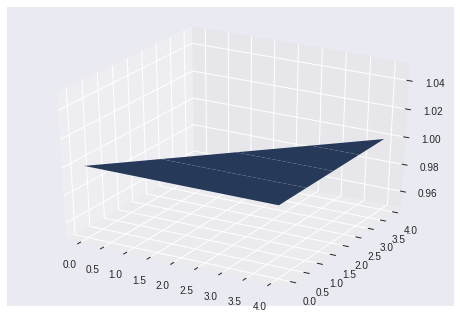

In [ ]:
Z = np.array([
    [ 1, 1, 1, 1, 1, ],
    [ 1, 1, 1, 1, 1, ],
    [ 1, 1, 1, 1, 1, ],
    [ 1, 1, 1, 1, 1, ],
    [ 1, 1, 1, 1, 1, ],
    ])

x, y = Z.shape

xs = np.arange(x)
ys = np.arange(y)
X, Y = np.meshgrid(xs, ys)


R = np.where(X>=Y, Z, np.nan)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, R, rstride=1, linewidth=0)

fig.show()

In [ ]:
domain = np.random.random((4, 5))
domain.astype(float)
domain *= np.tri(*domain.shape)
domain[domain == 0] = np.nan

domain[0][1] = 1
domain[1][2] = 1
domain[2][3] = 1
domain[2][4] = 1

domain[3][4] = 1

In [ ]:
#----- Generic solver
def matrixSolver(inputStepSize, domain, rhsEquation):
  # Solve poisson equation with domain given by unit squares in
  # matrix. The differential equation is then represented by a
  # matrix system of equations to solve.
  
  # Stride length
  steps = round(1 / inputStepSize)

  # Refining the domain using the kronecker product - 
  refinedDomain = np.kron(domain, np.ones(steps))
  
  # Fix x axis missing expanded values and boundaries
  leftSide = np.kron(refinedDomain[:, 0], np.ones(1, steps-1))
  leftBoundary = np.zeros(leftSide.shape[0], 1)
  rightBoundary = leftBoundary
  refinedDomain = np.vstack((belowBoundary, topBoundary, refinedDomain, bottomBoundary))

  # Fix y axis missing expanded values and boundaries
  belowboundary = np.kron(refinedDomain[0,:], np.ones(steps-1, 1))
  topBoundary = np.zeros(1, belowboundary.shape[1])
  bottomBoundary = topBoundary
  refinedDomain = [bottomBoundary, belowboundary, refinedDomain, topBoundary]

  # Find nonzero elements on the domain
  [yPoints, xPoints] = find(refinedDomain)

  # Scale x and y points based on step size
  xPoints = inputStepSize * xPoints
  yPoints = inputStepSize * yPoints

  # Initialize operator matrix with diagonals
  operatorMatrix = 4 * sparse.eye(xPoints.size).toarray()


  # Iterate through each neighborhood and assign -1 where necessary
  for i in range(xPoints.size):
      currentPoint = [xPoints[i], yPoints[i]]

      # Set up coordinates of surrounding points
      above = [currentPoint[0], currentPoint[1] + inputStepSize]
      below = [currentPoint[0], currentPoint[1] - inputStepSize]
      left = [currentPoint[0] - inputStepSize, currentPoint[1]]
      right = [currentPoint[0] + inputStepSize, currentPoint[1]]

      # Vector of surrounding points for easy iteration
      surroundingPoints = [above, below, left, right]

      # Retrieve individual indices for each 
      for j in range(surroundingPoints.size/2):
          idx = findPoint(xPoints, yPoints, [surroundingPoints[j][0], surroundingPoints[j][1]])
          operatorMatrix[i, idx] = -1

  # Create right hand side vector
  rhsVector = inputStepSize ** 2 * rhsEquation(xPoints, yPoints)

#   # Solve the system
#   solutionMatrix = operatorMatrix \ rhsVector;

#   # Coordinates plotted for visualization
#   [X, Y] = meshgrid(0:inputStepSize:size(domain, 2)+1, ...
#       0:inputStepSize:size(domain, 1)+1);

#   Z = refinedDomain;
#   for i=1:numel(solutionMatrix)
#       Z(find(Z == 1, 1)) = solutionMatrix(i);
  

#   # Remove values for x and y that are not internal or boundary points
#   zeroIndices = find(~conv2(Z, [1 1 1; 1 0 1; 1 1 1], 'same'));
#   X(zeroIndices) = np.nan;
#   Y(zeroIndices) = np.nan;
